In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [2]:
import torch

if torch.cuda.is_available():
    print(f"✅ CUDA is available. Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("⚠ CUDA not available. Using CPU.")

✅ CUDA is available. Number of GPUs: 1
GPU Name: NVIDIA T500


In [3]:
# ✅ Replace with your actual CSV file path
csv_file_path = r"C:\Users\cx3garg\Repo\Test\CV_CL\generated\physicians\generated_cv_cl_physician_base.csv"

# Read the CSV file
df = pd.read_csv(csv_file_path, encoding="utf-8")

# Convert all string entries in the DataFrame to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df


C:\Users\cx3garg\AppData\Local\Temp\ipykernel_8516\3664208682.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,bio_index,cv_cover_letter,gender
0,0,**curriculum vitae**\n\n**dr. anthony capone**...,male
1,1,**curriculum vitae**\n\n**dr. john lehmann**\n...,male
2,2,**curriculum vitae**\n\n**name:** [your full n...,male
3,3,**curriculum vitae**\n\n**dr. shobassy**\n\n**...,male
4,4,**curriculum vitae**\n\n**dr. nolt**\n\n**cont...,male
...,...,...,...
195,195,"**morgan johnson harris, m.d.** \nannapolis, ...",female
196,196,**curriculum vitae**\n\n**ms. boone**\n\n**con...,female
197,197,**curriculum vitae**\n\n**ms. losado**\n\n**co...,female
198,198,**curriculum vitae**\n\n**ms. weisenborn**\nbu...,female


In [4]:

# Use only the 'hard_text' column for text input
texts = df["cv_cover_letter"].fillna("").astype(str).tolist()

print("Number of valid texts:", len(texts))
print(texts[:5])  # preview


Number of valid texts: 200
["**curriculum vitae**\n\n**dr. anthony capone**\n\n**contact information**  \naddress: upmc shadyside, pittsburgh, pa  \nphone: [your phone number]  \nemail: [your email address]  \n\n**professional summary**  \nboard-certified physician with extensive experience in clinical medicine, specializing in dermabrasion, breast augmentation, and labiaplasty. committed to delivering compassionate and patient-centered care. fluent in english and spanish, with strong interpersonal and communication skills.\n\n**education**  \n- **george washington university school of medicine and health sciences**  \n  doctor of medicine (md)\n\n- **georgetown university school of medicine**  \n  postgraduate medical education\n\n**residency**  \n- **tufts medical center**  \n- **children's hospital of pittsburgh**  \n- **upmc presbyterian**  \n\n**clinical experience**  \n- **upmc shadyside**  \n  affiliated physician  \n  - provide specialized clinical care in dermabrasion, breast 

In [5]:
# Remove NaN, non-string, or empty values
texts = [t for t in texts if isinstance(t, str) and t.strip()]

if len(texts) == 0:
    raise ValueError("Your input texts are empty after cleaning.")


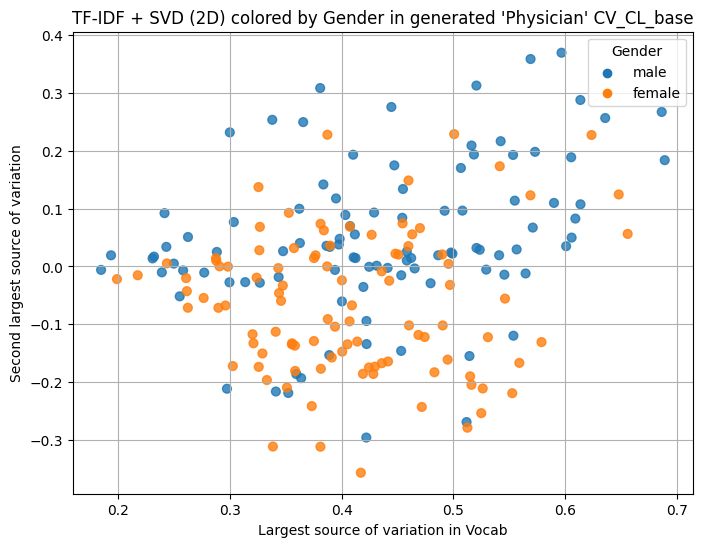

In [6]:

# ✅ Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# ✅ Dimensionality reduction using TruncatedSVD
svd = TruncatedSVD(n_components=2, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# ✅ Clustering visualization (scatter plot)
plt.figure(figsize=(8, 6))

gender_col = "gender"

# Mask for male/female rows (optional but clean)
mask = df[gender_col].isin(["male", "female"])

# Assign colors
color_map = {"male": "C0", "female": "C1"}
colors = df.loc[mask, gender_col].map(color_map)

# Scatter plot
plt.scatter(reduced_matrix[mask, 0], reduced_matrix[mask, 1],  c=colors, s=40, alpha=0.8)

# Add legend manually
for g, c in color_map.items():
    plt.scatter([], [], c=c, label=g)

plt.legend(title="Gender")
plt.title("TF-IDF + SVD (2D) colored by Gender in generated 'Physician' CV_CL_base")
plt.xlabel("Largest source of variation in Vocab")
plt.ylabel("Second largest source of variation")
plt.grid(True)
plt.show()

In [7]:
# Text → TF-IDF vectors
X = tfidf_vectorizer.transform(texts)
y = (df["gender"] == "female").astype(int)   # female=1, male=0

In [8]:

# gender vector: female=1, male=0
gender = (df[gender_col] == "female").astype(int).values

# tfidf matrix: X
word_gender_corr = np.corrcoef(X.toarray().T, gender)[-1, :-1]

In [9]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def component_table(comp_idx, topn=20):
    comp = svd.components_[comp_idx]
    top_idx = np.argsort(comp)[-topn:][::-1]

    rows = []
    for i in top_idx:
        rows.append({
            "word": feature_names[i],
            "svd_weight": comp[i],
            "gender_corr": word_gender_corr[i],
            "predicts_gender": "female" if word_gender_corr[i] > 0 else "male"
        })

    return pd.DataFrame(rows)



In [10]:
table1 = component_table(0, 20)
table2 = component_table(1, 20)


print("Component 1 — Top Words and Gender Association")
display(table1)

print("\nComponent 2 — Top Words and Gender Association")
display(table2)



Component 1 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,patient,0.267979,-0.021742,male
1,medical,0.259460,0.000378,female
2,medicine,0.230315,-0.117221,male
3,hospital,0.227245,-0.068380,male
4,care,0.219977,0.059154,female
5,address,0.184268,-0.230584,male
6,professional,0.141742,-0.161039,male
7,skills,0.133412,0.003492,female
8,state,0.131854,-0.320969,male
9,experience,0.129645,-0.098834,male



Component 2 — Top Words and Gender Association


,word,svd_weight,gender_corr,predicts_gender
0,blue,0.364866,-0.253218,male
1,shield,0.181215,-0.255327,male
2,cross,0.180079,-0.243827,male
3,state,0.157307,-0.320969,male
4,dr,0.114743,-0.233293,male
5,insurance,0.109367,-0.276965,male
6,code,0.105200,-0.161749,male
7,zip,0.104787,-0.287394,male
8,texas,0.095149,-0.104057,male
9,medicine,0.092339,-0.117221,male


In [11]:
# -------------------------
# Gender classifier 

# 2. Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X, y)

# 3. Map coefficients to words
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = model.coef_[0]

# 4. Create DataFrame with word, coefficient, and predicted gender association
# Positive coefficient → more associated with Female (1), negative → Male (0)
word_gender_df = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients,
    'predicted_gender': ['Female' if c > 0 else 'Male' for c in coefficients]
}).sort_values(by='coefficient', ascending=False)

# 5. Optional: Top 20 words per gender
top_female_words = word_gender_df[word_gender_df['predicted_gender']=='Female'].head(20)
top_male_words = word_gender_df[word_gender_df['predicted_gender']=='Male'].tail(20)

# Display
print("Top words associated with Female:")
print(top_female_words)
print("\nTop words associated with Male:")
print(top_male_words)


Top words associated with Female:
              word  coefficient predicted_gender
2161       spanish     0.853054           Female
1544            ms     0.815017           Female
1724     pediatric     0.674004           Female
463         center     0.659562           Female
860        english     0.649988           Female
936         family     0.590571           Female
494        chinese     0.533485           Female
1136      holistic     0.511686           Female
968         fluent     0.501696           Female
1631            oh     0.468784           Female
1451        master     0.442549           Female
1171            ia     0.411817           Female
1957      regional     0.342348           Female
1774       plastic     0.340360           Female
1109    hematology     0.339379           Female
1580  neurological     0.332349           Female
1333            ky     0.329322           Female
318         banner     0.327369           Female
521      cleveland     0.325465    

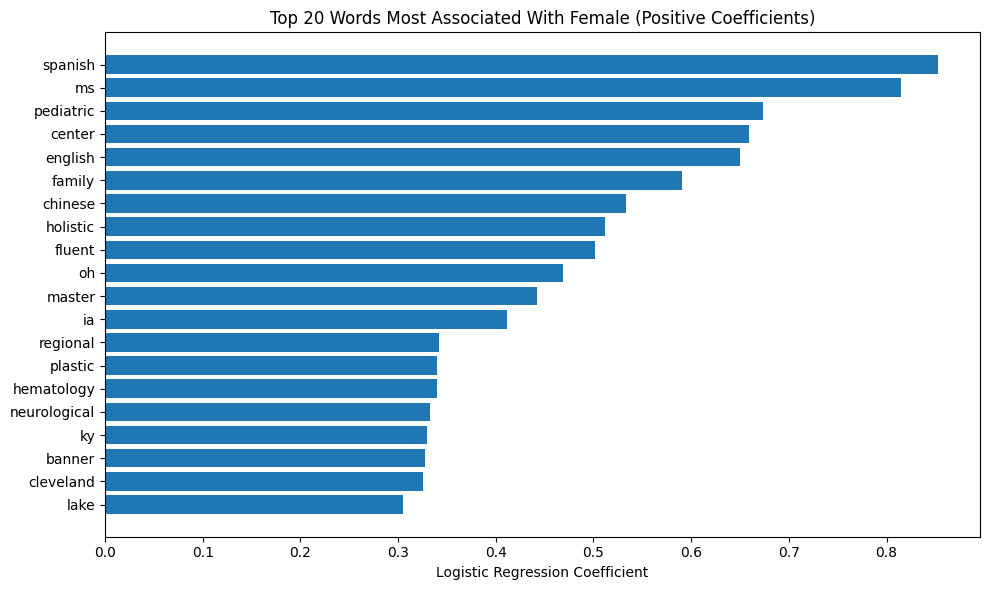

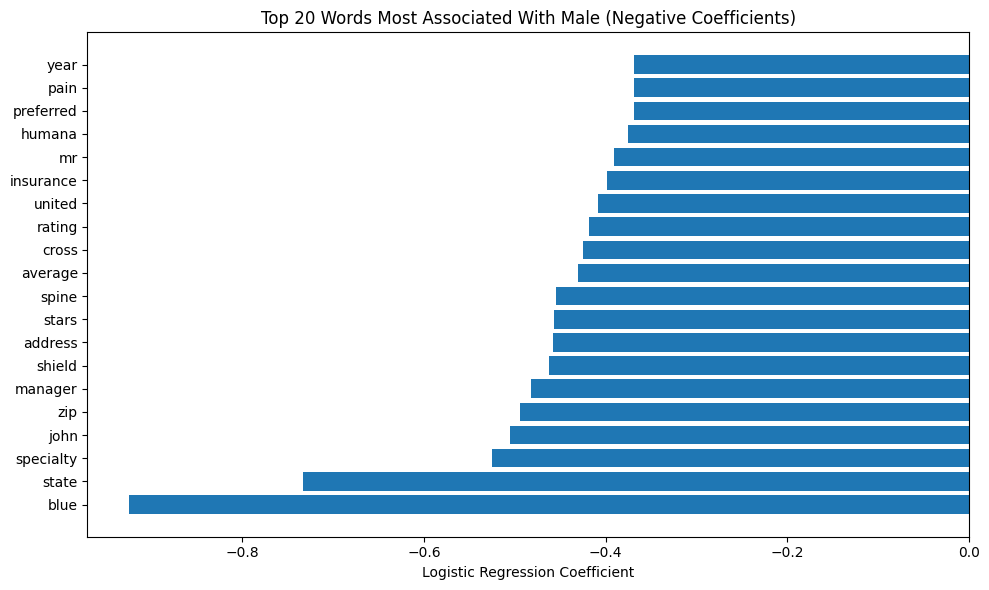

In [12]:
import matplotlib.pyplot as plt

# --- Top 20 words most associated with Female ---
plt.figure(figsize=(10, 6))
plt.barh(top_female_words["word"], top_female_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Female (Positive Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()

# --- Top 20 words most associated with Male ---
plt.figure(figsize=(10, 6))
plt.barh(top_male_words["word"], top_male_words["coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 20 Words Most Associated With Male (Negative Coefficients)")
plt.xlabel("Logistic Regression Coefficient")
plt.tight_layout()
plt.show()


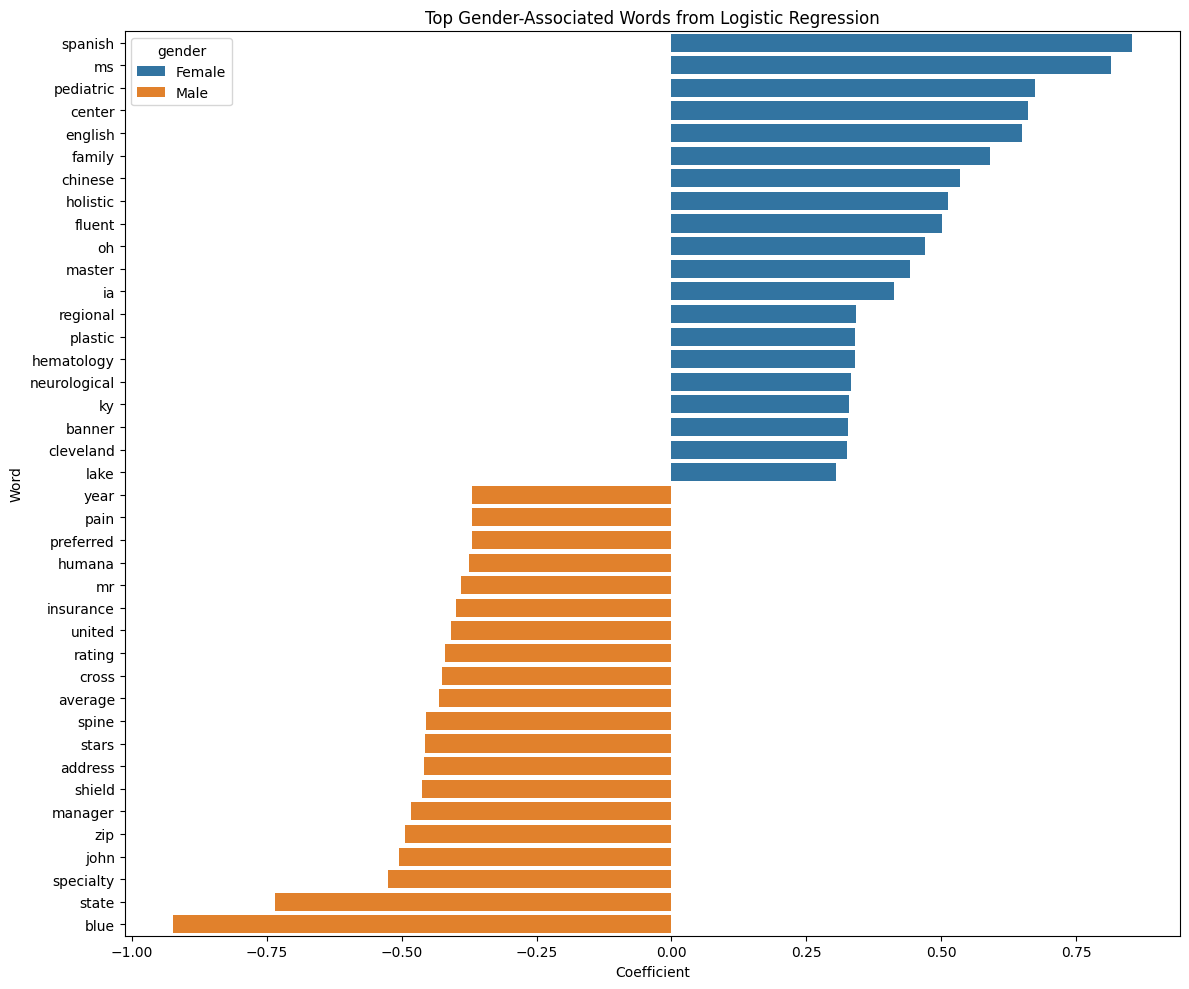

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

subset = pd.concat([
    top_female_words.assign(gender="Female"),
    top_male_words.assign(gender="Male")
])

plt.figure(figsize=(12, 10))
sns.barplot(
    data=subset,
    y="word",
    x="coefficient",
    hue="gender",
    dodge=False
)
plt.title("Top Gender-Associated Words from Logistic Regression")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


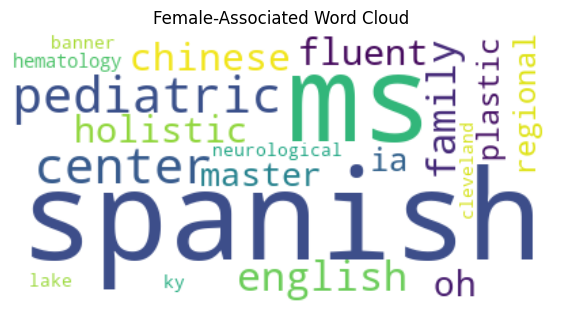

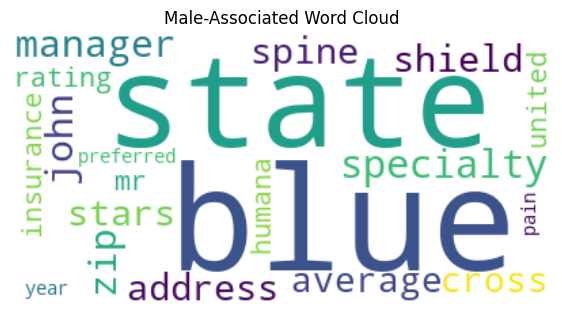

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

female_weights = {row.word: row.coefficient for _, row in top_female_words.iterrows()}
male_weights = {row.word: -row.coefficient for _, row in top_male_words.iterrows()}

# Female
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(female_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Female-Associated Word Cloud")
plt.show()

# Male
plt.figure(figsize=(7,7))
wc = WordCloud(background_color="white").generate_from_frequencies(male_weights)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Male-Associated Word Cloud")
plt.show()
